# Overview

In this notebook, we walk through the process of building a complete machine learning pipeline covering ingest, exploration, training, evaluation, deployment, and prediction. The machine learning model in TensorFlow will be developed on a small sample locally. The preprocessing operations will be implemented in Cloud Dataflow, so that the same preprocessing can be applied in streaming mode as well. The training of the model will then be distributed and scaled out on Cloud AI Platform. The trained model will be deployed as a microservice and predictions invoked from a web application.

![alt text](outline.png "outline")


This notebook consists of 8 parts:
1. Explore, visualize a dataset
2. Create sampled dataset
3. Develop a Tensorflow model
4. Create training and evaluation dataset
5. Execute training
6. Deploy prediction service
7. Automate
8. Invoke ML prediction



# 1. Explore, visualize a dataset

Illustrates:

- Exploring a BigQuery dataset using AI Platform Notebooks.

In [1]:
# change these to try this notebook out
BUCKET = 'lidldatascientistadvanalytics'
PROJECT = 'lidldatascientistadvanalytics'
REGION = 'us-central1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

The data is "The Ultimate Halloween Candy Power Ranking" (What’s the most popular Halloween candy?). That was the question this dataset was collected to answer. Data was collected by creating a website where participants were shown [presenting two fun-sized candies and asked to click on the one they would prefer to receive](http://walthickey.com/2017/10/18/whats-the-best-halloween-candy/). In total, more than 269 thousand votes were collected from 8,371 different IP addresses.

The dataset includes attributes for each candy along with its ranking. For binary variables, 1 means yes, 0 means no. The data contains the following fields:

- chocolate: Does it contain chocolate?
- fruity: Is it fruit flavored?
- caramel: Is there caramel in the candy?
- peanutalmondy: Does it contain peanuts, peanut butter or almonds?
- nougat: Does it contain nougat?
- crispedricewafer: Does it contain crisped rice, wafers, or a cookie component?
- hard: Is it a hard candy?
- bar: Is it a candy bar?
- pluribus: Is it one of many candies in a bag or box?
- sugarpercent: The percentile of sugar it falls under within the data set.
- pricepercent: The unit price percentile compared to the rest of the set.
- winpercent: The overall win percentage according to 269,000 matchups.

My goal is to predict the ranking of a new candy given a number of factors about the attributes. Later, we will want to split the data into training and eval datasets. 



In [4]:
# Create SQL query using candy_data
query = """
SELECT
    competitorname, 
    chocolate, 
    fruity, 
    caramel, 
    peanutyalmondy, 
    nougat, 
    crispedricewafer, 
    hard, 
    bar, 
    pluribus, 
    sugarpercent, 
    pricepercent, 
    winpercent
FROM
  lidldatascientistadvanalytics.candy_data.original
ORDER BY winpercent DESC
"""

In [5]:
# Call BigQuery and examine in dataframe
from google.cloud import bigquery
df = bigquery.Client().query(query + " LIMIT 10").to_dataframe()
df.head()

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,ReeseÕs Peanut Butter cup,1,0,0,1,0,0,0,0,0,0.720,0.651,84.180290
1,ReeseÕs Miniatures,1,0,0,1,0,0,0,0,0,0.034,0.279,81.866257
2,Twix,1,0,1,0,0,1,0,1,0,0.546,0.906,81.642914
3,Kit Kat,1,0,0,0,0,1,0,1,0,0.313,0.511,76.768600
4,Snickers,1,0,1,1,1,0,0,1,0,0.546,0.651,76.673782


Let's write a query to find the unique values for each of the columns and the count of those values. This is important to ensure that we have enough examples of each data value, and to verify our hunch that the parameter has predictive value.

In [6]:
# Create function that finds the number of records and the average weight for each value of the chosen column
def get_distinct_values(column_name):
  sql = """
SELECT
  {0},
  COUNT(1) AS num_candies,
  AVG(winpercent) AS avg_rank
FROM
  lidldatascientistadvanalytics.candy_data.original
GROUP BY
  {0}
  """.format(column_name)
  return bigquery.Client().query(sql).to_dataframe()

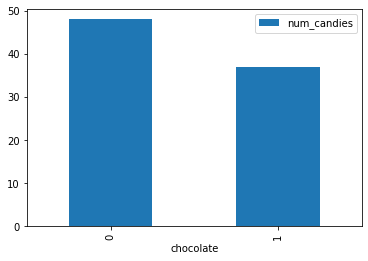

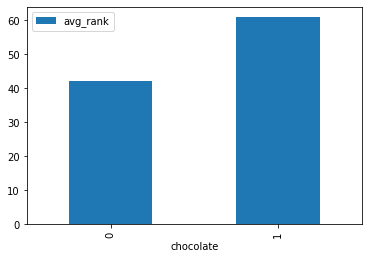

In [7]:
# Bar plot to see is_male with avg_wt linear and num_babies logarithmic
%matplotlib inline
df = get_distinct_values('chocolate')
df.plot(x='chocolate', y='num_candies', kind='bar');
df.plot(x='chocolate', y='avg_rank', kind='bar');

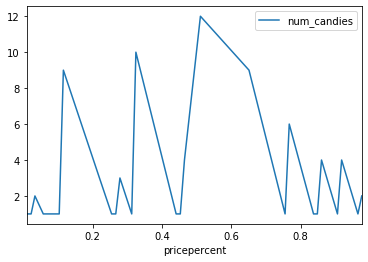

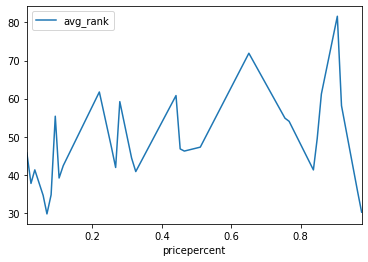

In [8]:
# Line plots to see mother_age with avg_wt linear and num_babies logarithmic
df = get_distinct_values('pricepercent')
df = df.sort_values('pricepercent')
df.plot(x='pricepercent', y='num_candies');
df.plot(x='pricepercent', y='avg_rank');

All these factors seem to play a part in the candy ranking. Chocolate is more popular on average. More expensive candies tend to be more popular. Preemies weigh in lower as do babies born to single moms. In addition, it is important to check whether you have enough data (number of candies) for each input value. Otherwise, the model prediction against input values that doesn't have enough data may not be reliable.

In the next section, I will develop a machine learning model to combine all of these factors to come up with a prediction of a candies ranking.

# 2. Create sampled dataset

Illustrates:

- Sampling a BigQuery dataset to create datasets for ML
- Preprocessing with Pandas

Let's sample the BigQuery data to create smaller datasets. 

In [9]:
# Create SQL query using candy_data
query = """
SELECT
    ABS(FARM_FINGERPRINT(competitorname)) AS hashname,
    chocolate, 
    fruity, 
    caramel, 
    peanutyalmondy, 
    nougat, 
    crispedricewafer, 
    hard, 
    bar, 
    pluribus, 
    sugarpercent, 
    pricepercent, 
    winpercent
FROM
  lidldatascientistadvanalytics.candy_data.original
"""

In [10]:
# Call BigQuery but GROUP BY the hashname and see number of records for each group to enable us to get the correct train and evaluation percentages
df = bigquery.Client().query("SELECT hashname, COUNT(winpercent) AS num_candies FROM (" + query + ") GROUP BY hashname ORDER BY num_candies").to_dataframe()
print("There are {} unique hashnames.".format(len(df)))
df.head()

There are 85 unique hashnames.


,hashname,num_candies
0,7046859833195853823,1
1,9167499499902123141,1
2,1631755363487315696,1
3,1606999616445289157,1
4,5825011382060312997,1


competitorname seems to be unique. Let's get a well distributed portion (half) of the data in such a way that the test and train sets do not overlap:

In [11]:
# Added the RAND() so that we can now subsample from each of the hashnames to get approximately the record counts we want
trainQuery = "SELECT * FROM (" + query + ") WHERE MOD(hashname, 4) < 3 AND RAND() < 0.5"
evalQuery = "SELECT * FROM (" + query + ") WHERE MOD(hashname, 4) = 3 AND RAND() < 0.5"
traindf = bigquery.Client().query(trainQuery).to_dataframe()
evaldf = bigquery.Client().query(evalQuery).to_dataframe()
print("There are {} examples in the train dataset and {} in the eval dataset".format(len(traindf), len(evaldf)))

There are 33 examples in the train dataset and 8 in the eval dataset


## Preprocess data using Pandas

In [12]:
traindf.head()


,hashname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,1631755363487315696,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
1,5825011382060312997,0,1,0,0,0,0,1,0,0,0.732,0.034,39.460556
2,7515611997518725754,0,1,0,0,0,0,1,0,0,0.046,0.104,39.141056
3,7524574358447315246,0,1,0,0,0,0,0,0,0,0.267,0.279,52.911392
4,5798036444257969148,0,0,1,0,0,0,0,0,0,0.418,0.325,32.230995


Also notice that there may be some very important numeric fields that are missing in some rows (the count in Pandas doesn't count missing data)

In [13]:
# Let's look at a small sample of the training data
traindf.describe()

,hashname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
count,3.300000e+01,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,5.004548e+18,0.454545,0.454545,0.181818,0.121212,0.090909,0.060606,0.212121,0.272727,0.424242,0.485000,0.450182,49.518915
std,2.623669e+18,0.505650,0.505650,0.391675,0.331434,0.291937,0.242306,0.415149,0.452267,0.501890,0.302436,0.316590,13.747774
min,2.200173e+17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034000,0.011000,24.524988
25%,2.709891e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.220000,0.220000,39.460556
50%,5.681992e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.430000,0.325000,48.982651
75%,7.003547e+18,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.732000,0.767000,56.914547
max,8.355668e+18,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.965000,0.918000,81.866257


It is always crucial to clean raw data before using in ML, so we have a preprocessing step. Our data are clean, but this is not general the case.

In [14]:
import pandas as pd
def preprocess(df):
  # clean up data we don't want to train on
  # in other words, users will have to tell us the mother's age
  # otherwise, our ML service won't work.
  # these were chosen because they are such good predictors
  # and because these are easy enough to collect
  df = df[df.sugarpercent > 0]
  df = df[df.pricepercent > 0]
  df = df[df.winpercent > 0]
  return df
traindf = preprocess(traindf)
evaldf = preprocess(evaldf)
# Describe only does numeric columns
traindf.describe()

,hashname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
count,3.300000e+01,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,5.004548e+18,0.454545,0.454545,0.181818,0.121212,0.090909,0.060606,0.212121,0.272727,0.424242,0.485000,0.450182,49.518915
std,2.623669e+18,0.505650,0.505650,0.391675,0.331434,0.291937,0.242306,0.415149,0.452267,0.501890,0.302436,0.316590,13.747774
min,2.200173e+17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034000,0.011000,24.524988
25%,2.709891e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.220000,0.220000,39.460556
50%,5.681992e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.430000,0.325000,48.982651
75%,7.003547e+18,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.732000,0.767000,56.914547
max,8.355668e+18,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.965000,0.918000,81.866257


## Write out

In the final versions, we want to read from files, not Pandas dataframes. So, write the Pandas dataframes out as CSV files. Using CSV files gives us the advantage of shuffling during read. This is important for distributed training because some workers might be slower than others, and shuffling the data helps prevent the same data from being assigned to the slow workers.

In [15]:
traindf.to_csv('train.csv', index=False, header=False)
evaldf.to_csv('eval.csv', index=False, header=False)

In [16]:
%%bash
wc -l *.csv
head *.csv
tail *.csv

      86 candy-data.csv
       8 eval.csv
      33 train.csv
     127 total
==> candy-data.csv <==
competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
100 Grand,1,0,1,0,0,1,0,1,0,.73199999,.86000001,66.971725
3 Musketeers,1,0,0,0,1,0,0,1,0,.60399997,.51099998,67.602936
One dime,0,0,0,0,0,0,0,0,0,.011,.116,32.261086
One quarter,0,0,0,0,0,0,0,0,0,.011,.51099998,46.116505
Air Heads,0,1,0,0,0,0,0,0,0,.90600002,.51099998,52.341465
Almond Joy,1,0,0,1,0,0,0,1,0,.465,.76700002,50.347546
Baby Ruth,1,0,1,1,1,0,0,1,0,.60399997,.76700002,56.914547
Boston Baked Beans,0,0,0,1,0,0,0,0,1,.31299999,.51099998,23.417824
Candy Corn,0,0,0,0,0,0,0,0,1,.90600002,.32499999,38.010963

==> eval.csv <==
469386622034516271,0,0,0,1,0,0,0,0,1,0.31299999,0.51099998,23.417824
7783993432492371191,0,1,0,0,0,0,0,0,1,0.73199999,0.51099998,36.017628
4481441026703841371,0,1,0,0,0,0,0,0,1,0.127,0.034000002,43.088924
882432006871638671,0,1,0,0,

# 3. Develop a Tensorflow model

Illustrates:
- Creating a model using the high-level Estimator API

In [17]:
%%bash
ls *.csv

candy-data.csv
eval.csv
train.csv


## Create TensorFlow model using TensorFlow's Estimator API

First, write an input_fn to read the data.

In [18]:
import shutil
import numpy as np
import tensorflow as tf
print(tf.__version__)

1.13.1


In [19]:
# Determine CSV, label, and key columns
CSV_COLUMNS = 'hashname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent'.split(',')
LABEL_COLUMN = 'winpercent'
KEY_COLUMN = 'hashname'

# Set default values for each CSV column
DEFAULTS = [['nokey'],[0], [0], [0], [0], [0], [0], [0], [0], [0],  [0.0], [0.0], [0.0]]
TRAIN_STEPS = 1000

TensorFlow estimators work with input functions. The signature of an input function returns a tuple of features and labels. Features are a dictionary of feature names and numeric value arrays. Labels are an array of values. 

In [20]:
# Create an input function reading a file using the Dataset API
# Then provide the results to the Estimator API
def read_dataset(filename, mode, batch_size = 512):
  def _input_fn():
    def decode_csv(value_column):
      columns = tf.decode_csv(value_column, record_defaults=DEFAULTS)
      features = dict(zip(CSV_COLUMNS, columns))
      label = features.pop(LABEL_COLUMN)
      return features, label
    
    # Create list of files that match pattern
    file_list = tf.gfile.Glob(filename)

    # Create dataset from file list
    dataset = (tf.data.TextLineDataset(file_list)  # Read text file
                 .map(decode_csv))  # Transform each elem by applying decode_csv fn
      
    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # indefinitely
        dataset = dataset.shuffle(buffer_size=10*batch_size)
    else:
        num_epochs = 1 # end-of-input after this
 
    dataset = dataset.repeat(num_epochs).batch(batch_size)
    return dataset
  return _input_fn

Next, define the feature columns

In [21]:
# Define feature columns
def get_categorical(name, values):
  return tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(name, values))

def get_cols():
  # Define column types
  return [\
          get_categorical('chocolate', [0, 1]),
          get_categorical('fruity', [0, 1]),
          get_categorical('caramel', [0, 1]),
          get_categorical('peanutyalmondy', [0, 1]),
          get_categorical('nougat', [0, 1]),
          get_categorical('crispedricewafer', [0, 1]),
          get_categorical('hard', [0, 1]),
          get_categorical('bar', [0, 1]),
          get_categorical('pluribus', [0, 1]),
          tf.feature_column.numeric_column('sugarpercent'),
          tf.feature_column.numeric_column('pricepercent')
         ]

You need a serving input function if you want your model to be able to make predictions. The serving_input_fn specifies what the caller of the predict() method will have to provide. You are essentially telling the model what data it has to get from the user.

In [22]:
# Create serving input function to be able to serve predictions later using provided inputs
def serving_input_fn():
    feature_placeholders = {
        'chocolate': tf.placeholder(tf.int64, [None]),
        'fruity': tf.placeholder(tf.int64, [None]),
        'caramel': tf.placeholder(tf.int64, [None]),
        'peanutyalmondy': tf.placeholder(tf.int64, [None]),
        'nougat': tf.placeholder(tf.int64, [None]),
        'crispedricewafer': tf.placeholder(tf.int64, [None]),
        'hard': tf.placeholder(tf.int64, [None]),
        'bar': tf.placeholder(tf.int64, [None]),
        'pluribus': tf.placeholder(tf.int64, [None]),
        'sugarpercent': tf.placeholder(tf.float32, [None]),
        'pricepercent': tf.placeholder(tf.float32, [None]),
    }
    features = {
        key: tf.expand_dims(tensor, -1)
        for key, tensor in feature_placeholders.items()
    }
    return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

In [23]:
# Create estimator to train and evaluate
def train_and_evaluate(output_dir):
  EVAL_INTERVAL = 300
  run_config = tf.estimator.RunConfig(save_checkpoints_secs = EVAL_INTERVAL,
                                      keep_checkpoint_max = 3)
  estimator = tf.estimator.DNNRegressor(
                       model_dir = output_dir,
                       feature_columns = get_cols(),
                       hidden_units = [64, 32],
                       config = run_config)
  train_spec = tf.estimator.TrainSpec(
                       input_fn = read_dataset('train.csv', mode = tf.estimator.ModeKeys.TRAIN),
                       max_steps = TRAIN_STEPS)
  exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(
                       input_fn = read_dataset('eval.csv', mode = tf.estimator.ModeKeys.EVAL),
                       steps = None,
                       start_delay_secs = 60, # start evaluating after N seconds
                       throttle_secs = EVAL_INTERVAL,  # evaluate every N seconds
                       exporters = exporter)
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Finally, train!

In [25]:
# Run the model
shutil.rmtree('candy_trained', ignore_errors = True) # start fresh each time
tf.summary.FileWriterCache.clear() # ensure filewriter cache is clear for TensorBoard events file
train_and_evaluate('candy_trained')

INFO:tensorflow:Using config: {'_model_dir': 'candy_trained', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 300, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x129f10048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate 

The exporter directory contains the final model.

In [27]:
%%bash
ls ./candy_trained/*

./candy_trained/checkpoint
./candy_trained/events.out.tfevents.1567740950.Trix.local
./candy_trained/graph.pbtxt
./candy_trained/model.ckpt-0.data-00000-of-00002
./candy_trained/model.ckpt-0.data-00001-of-00002
./candy_trained/model.ckpt-0.index
./candy_trained/model.ckpt-0.meta
./candy_trained/model.ckpt-1000.data-00000-of-00002
./candy_trained/model.ckpt-1000.data-00001-of-00002
./candy_trained/model.ckpt-1000.index
./candy_trained/model.ckpt-1000.meta

./candy_trained/eval:
events.out.tfevents.1567740977.Trix.local

./candy_trained/export:
exporter


## Monitor and experiment with training

To begin TensorBoard from within AI Platform Notebooks, click the + symbol in the top left corner and select the Tensorboard icon to create a new TensorBoard.
In TensorBoard, look at the learned embeddings. Are they getting clustered? How about the weights for the hidden layers? What if you run this longer? What happens if you change the batchsize?

In [31]:
#loading the TensorBoard notebook extension
os.environ['TENSORBOARD_BINARY'] = "/anaconda3/envs/gcstf/bin/tensorboard"
%load_ext tensorboard.notebook
%tensorboard --logdir {'candy_trained'}

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


Launching TensorBoard...

FileNotFoundError: [Errno 2] No such file or directory: 'tensorboard': 'tensorboard'

# 4. Create training and evaluation dataset

# 5. Execute training

# 6. Deploy prediction service

# 7. Automate

# 8. Invoke ML prediction